In [120]:
%matplotlib inline 
#有了matplotlib inline 就可以省掉plt.show()了
%load_ext autoreload
%autoreload 2

from __future__ import division
from imports import *
#import pylab #使用pylab模式，可以直接使用numpy、pandas和绘图，而不需要再次引入,会配置为使用你所指定的matplotlib gui后端，还会提供一种更接近于matlab的界面
#%pylab
from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle code</button>""", raw=True)
# 允许多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from sklearn import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Toggle code

## 算法调参

### 机器学习算法调参
参数分两种：
* 影响模型在训练集上的准确度或防止过拟合能力的参数
* 另一种是不影响这两者的参数  
一般是针对第一种参数进行调整  
最终的效果是：模型在训练集上的准确度和防止过拟合能力的大和谐

### 网格搜索优化参数
通过遍历已定义参数的列表，来评估算法的参数，从而找到最优参数。

In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
filename = './csvs/user_label_7day_0301.csv'
datasource = pd.read_csv(filename)
data = datasource[datasource['user_label_7day.fplatformname']=='新浪平台']
array = data.values
X = array[:,5:9].astype(np.int64)
Y = array[:,9].astype(np.int64)
num_folds = 10
seed = 7
kfold = KFold(n_splits=num_folds,random_state=seed)

In [4]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
model = Ridge()
# 设置要遍历的参数
param_grid = {'alpha':[1,0.1,0.01,0.001,0]}
# 通过网格搜索查询最优参数
grid = GridSearchCV(estimator=model,param_grid=param_grid)
grid.fit(X,Y)
print('最高得分：%.3f'% grid.best_score_)
print('最优参数: %s'% grid.best_estimator_.alpha)

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

最高得分：-0.022
最优参数: 1


### 随机搜索优化参数
通过固定次数的迭代，采用随机采样分布的方式搜索何时的参数。

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

model = Ridge()
param_grid = {'alpha':uniform()}
grid = RandomizedSearchCV(estimator=model,param_distributions=param_grid,n_iter=100,random_state=7)
grid.fit(X,Y)
print('最高得分：%.3f'%grid.best_score_)
print(grid.best_estimator_.alpha)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x07349830>},
          pre_dispatch='2*n_jobs', random_state=7, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

最高得分：-0.022
0.977989511997


## 结果部署

### 持久化加载模型
在实际的项目中，需要将生成的模型序列化，并将其发布到生产环境。当有新数据出现时，需要反序列化已保存的模型，然后用其预测新的数据。

#### 通过pickle序列化和反序列化机器学习的模型
pickle是标准的Python序列化的方法

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from pickle import dump
from pickle import load
test_size = 0.33
seed = 4
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=test_size,random_state=seed)

# 训练模型
model = LogisticRegression()
model.fit(X_train,Y_train)

# 保存模型
model_file = './csvs/test.sav'
with open(model_file,'wb') as model_f:
    # 模型序列化
    dump(model,model_f)
    
# 加载模型
with open(model_file,'rb') as model_f:
    # 模型反序列化
    loaded_model = load(model_f)
    result = loaded_model.score(X_test,Y_test)
    print("算法评估结果：%.3f%%"%(result*100))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

算法评估结果：95.833%


#### 通过joblib序列化和反序列化机器学习的模型
joblib是scipy生态环境的一部分，提供了通用的工具来序列化Python的对象和反序列化。

In [8]:
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
# 保存模型
model_file = './csvs/test_joblib.sav'
with open(model_file,'wb') as model_f:
    # 模型序列化
    dump(model,model_f)
    
# 加载模型
with open(model_file,'rb') as model_f:
    # 模型反序列化
    loaded_model = load(model_f)
    result = loaded_model.score(X_test,Y_test)
    print("算法评估结果：%.3f%%"%(result*100))

算法评估结果：95.833%


# 项目实践

### 预测模型项目模板

#### 在项目中实践机器学习
1. 定义问题
    * 导入类库
    * 导入数据集
2. 理解数据
    * 描述性统计
    * 数据可视化
3. 数据准备
    * 数据清洗
    * 特征选择
    * 数据转换
4. 评估算法
    * 分离数据集
    * 定义模型评估标准
    * 算法审查
    * 算法比较
5. 优化模型
    * 算法调参
    * 集成算法
6. 结果部署
    * 预测评估数据集
    * 利用整个数据集生成模型
    * 序列化模型
    
当有新的机器学习项目时，新建一个Python文件，并将这个模板粘贴进去，再按照前面介绍的方法将其填充到每一个步骤中

> 使用模板的小技巧  
* 快速执行一遍
* 循环：重复步骤3~5
* 尝试每一个步骤
* 定向准确度：要确保每次改变都会给结果带来正向的影响



### 回归项目实例

#### 定义问题
预测波士顿房价

In [33]:
from sklearn.datasets import load_boston
boston = load_boston()
y = boston.target
datay = pd.DataFrame(y)
names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PRTATIO','B','LSTAT']
data = pd.DataFrame(boston.data)
data.columns = names
data['MEDV'] = datay
#data.dtypes

In [84]:
# 理解数据
data.shape
data.dtypes
data.head(10)
# 描述统计
pd.set_option('precision',1)
data.describe()
# 关联关系
pd.set_option('precision',2) # 两位小数
pearson = DataFrame(data.corr(method='pearson'))
a = pearson[(pearson> 0.7) | (pearson<-0.7) & (pearson !=1.0)]
a
# >0.7或<-0.7具有强关联关系


(506, 14)

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PRTATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRTATIO,B,LSTAT,MEDV
0,6.32e-03,18.0,2.31,0.0,0.54,6.58,65.2,4.09,1.0,296.0,15.3,396.90,4.98,24.0
1,2.73e-02,0.0,7.07,0.0,0.47,6.42,78.9,4.97,2.0,242.0,17.8,396.90,9.14,21.6
2,2.73e-02,0.0,7.07,0.0,0.47,7.18,61.1,4.97,2.0,242.0,17.8,392.83,4.03,34.7
3,3.24e-02,0.0,2.18,0.0,0.46,7.00,45.8,6.06,3.0,222.0,18.7,394.63,2.94,33.4
4,6.91e-02,0.0,2.18,0.0,0.46,7.15,54.2,6.06,3.0,222.0,18.7,396.90,5.33,36.2
5,2.99e-02,0.0,2.18,0.0,0.46,6.43,58.7,6.06,3.0,222.0,18.7,394.12,5.21,28.7
6,8.83e-02,12.5,7.87,0.0,0.52,6.01,66.6,5.56,5.0,311.0,15.2,395.60,12.43,22.9
7,1.45e-01,12.5,7.87,0.0,0.52,6.17,96.1,5.95,5.0,311.0,15.2,396.90,19.15,27.1
8,2.11e-01,12.5,7.87,0.0,0.52,5.63,100.0,6.08,5.0,311.0,15.2,386.63,29.93,16.5
9,1.70e-01,12.5,7.87,0.0,0.52,6.00,85.9,6.59,5.0,311.0,15.2,386.71,17.10,18.9


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRTATIO,B,LSTAT,MEDV
count,5.1e+02,506.0,506.0,5.1e+02,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0
mean,3.6e+00,11.4,11.1,6.9e-02,0.6,6.3,68.6,3.8,9.5,408.2,18.5,356.7,12.7,22.5
std,8.6e+00,23.3,6.9,2.5e-01,0.1,0.7,28.1,2.1,8.7,168.5,2.2,91.3,7.1,9.2
min,6.3e-03,0.0,0.5,0.0e+00,0.4,3.6,2.9,1.1,1.0,187.0,12.6,0.3,1.7,5.0
25%,8.2e-02,0.0,5.2,0.0e+00,0.4,5.9,45.0,2.1,4.0,279.0,17.4,375.4,6.9,17.0
50%,2.6e-01,0.0,9.7,0.0e+00,0.5,6.2,77.5,3.2,5.0,330.0,19.1,391.4,11.4,21.2
75%,3.6e+00,12.5,18.1,0.0e+00,0.6,6.6,94.1,5.2,24.0,666.0,20.2,396.2,17.0,25.0
max,8.9e+01,100.0,27.7,1.0e+00,0.9,8.8,100.0,12.1,24.0,711.0,22.0,396.9,38.0,50.0


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRTATIO,B,LSTAT,MEDV
CRIM,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INDUS,NaN,NaN,1.00,NaN,0.76,NaN,NaN,-0.71,NaN,0.72,NaN,NaN,NaN,NaN
CHAS,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOX,NaN,NaN,0.76,NaN,1.00,NaN,0.73,-0.77,NaN,NaN,NaN,NaN,NaN,NaN
RM,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGE,NaN,NaN,NaN,NaN,0.73,NaN,1.00,-0.75,NaN,NaN,NaN,NaN,NaN,NaN
DIS,NaN,NaN,-0.71,NaN,-0.77,NaN,-0.75,1.00,NaN,NaN,NaN,NaN,NaN,NaN
RAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.91,NaN,NaN,NaN,NaN
TAX,NaN,NaN,0.72,NaN,NaN,NaN,NaN,NaN,0.91,1.00,NaN,NaN,NaN,NaN


### 数据可视化
#### 单一特征图表

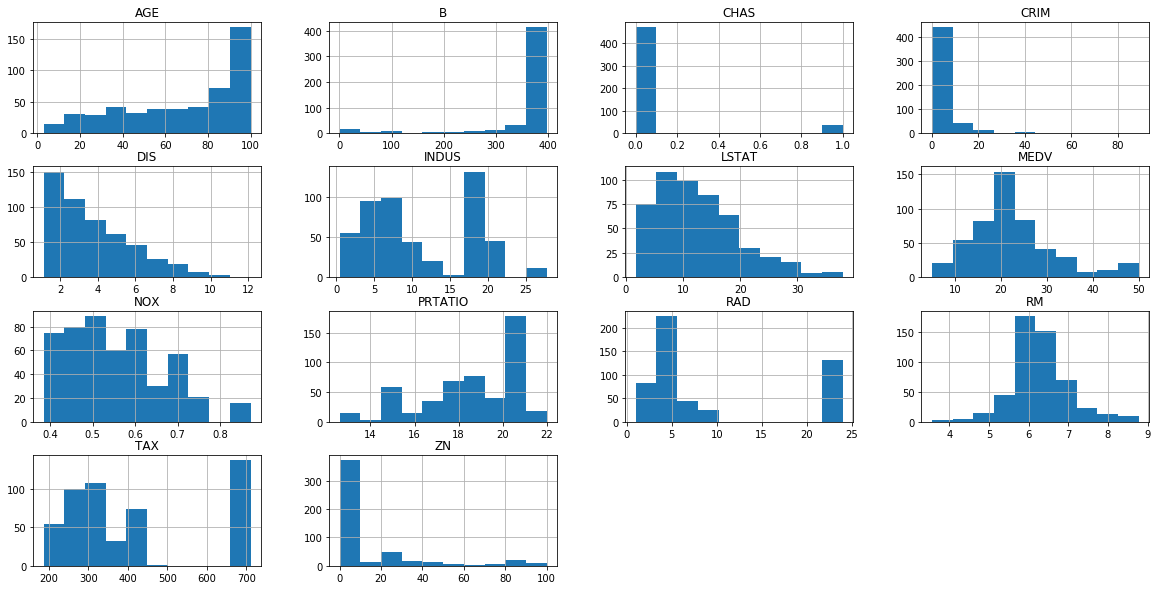

In [87]:
# 首先查看每一个数据特征单独的分布图
# 可以通过查看各个数据特征的直方图，来感受一下数据的分布情况
from IPython.core.pylabtools import figsize
figsize(20,10)
data.hist(sharex=False,sharey=False);

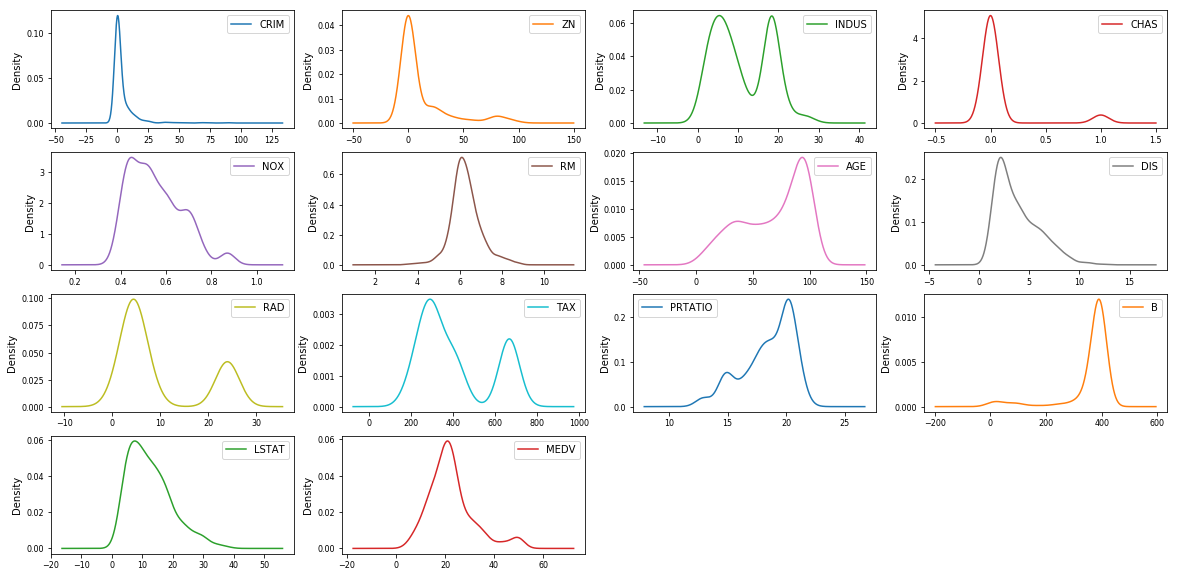

In [93]:
# 通过密度图可以更加平滑地展示这些数据特征
data.plot(kind='kde',subplots=True,layout=(4,4),sharex=False,fontsize=8);

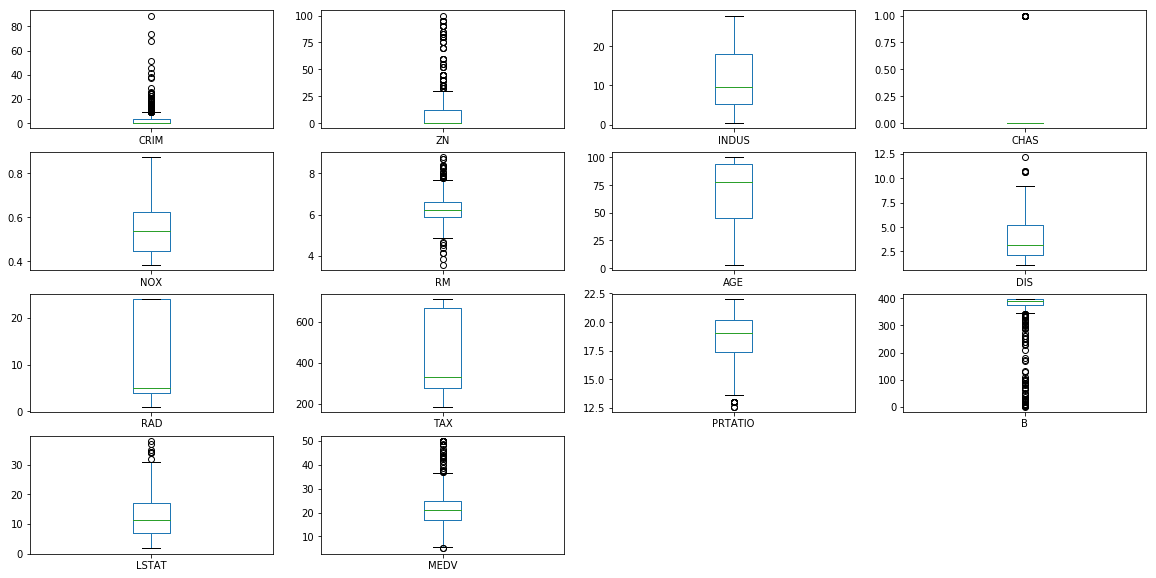

In [95]:
# 通过箱线图可以查看每一个数据特征的情况
data.plot(kind='box',subplots=True,layout=(4,4),sharey=False);

#### 多重数据图表

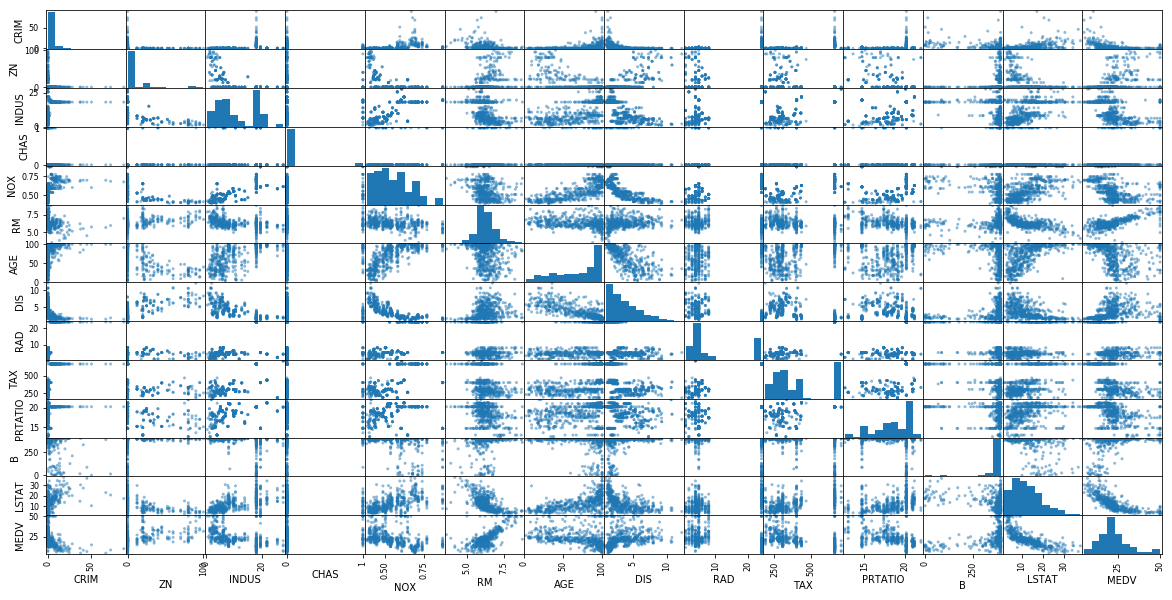

In [97]:
# 散点矩阵图
scatter_matrix(data);

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRTATIO,B,LSTAT,MEDV
CRIM,1.00,-0.20,0.40,-5.53e-02,0.42,-0.22,0.35,-0.38,6.22e-01,0.58,0.29,-0.38,0.45,-0.39
ZN,-0.20,1.00,-0.53,-4.27e-02,-0.52,0.31,-0.57,0.66,-3.12e-01,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.40,-0.53,1.00,6.29e-02,0.76,-0.39,0.64,-0.71,5.95e-01,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00e+00,0.09,0.09,0.09,-0.10,-7.37e-03,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,9.12e-02,1.00,-0.30,0.73,-0.77,6.11e-01,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,9.13e-02,-0.30,1.00,-0.24,0.21,-2.10e-01,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,8.65e-02,0.73,-0.24,1.00,-0.75,4.56e-01,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-9.92e-02,-0.77,0.21,-0.75,1.00,-4.95e-01,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.62,-0.31,0.60,-7.37e-03,0.61,-0.21,0.46,-0.49,1.00e+00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-3.56e-02,0.67,-0.29,0.51,-0.53,9.10e-01,1.00,0.46,-0.44,0.54,-0.47


[Text(0,1,'CRIM'),
 Text(0,1,'ZN'),
 Text(0,1,'INDUS'),
 Text(0,1,'CHAS'),
 Text(0,1,'NOX'),
 Text(0,1,'RM'),
 Text(0,1,'AGE'),
 Text(0,1,'DIS'),
 Text(0,1,'RAD')]

[Text(0,0,'CRIM'),
 Text(0,0,'ZN'),
 Text(0,0,'INDUS'),
 Text(0,0,'CHAS'),
 Text(0,0,'NOX'),
 Text(0,0,'RM'),
 Text(0,0,'AGE'),
 Text(0,0,'DIS'),
 Text(0,0,'RAD')]

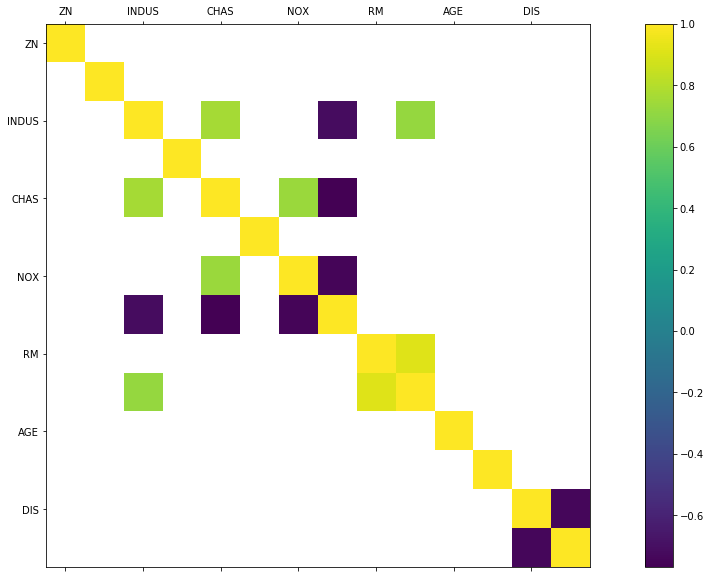

In [104]:
# 相关矩阵图
data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(a)
fig.colorbar(cax)
ax.set_xticklabels(names)
ax.set_yticklabels(names)

#### 思路总结
通过数据的相关性和数据的分布，发现数据集的数据结构比较复杂，需要考虑对数据进行转换，以提高模型的准确度。  
* 通过特征选择来减少大部分相关性高的特征
* 通过标准化数据来降低不同数据度量单位带来的影响
* 通过正态化数据来降低不同的数据分布结构，以提高算法的准确度

### 分离数据集


In [107]:
array = data.values
X = array[:,0:13]
Y = array[:,13]
validation_size = 0.2
seed = 7
X_train,X_validation,Y_train,Y_validation = train_test_split(X,Y,test_size=validation_size,random_state=seed)

### 评估算法

KNN: -41.896488(13.901688)
SVM: -85.518342(31.994798)
CART: -21.846927(10.303529)
EN: -27.504052(12.309801)
LR: -21.400099(9.390450)
LASSO: -26.431547(11.655308)


{'boxes': [<matplotlib.lines.Line2D at 0x1c149270>,
 'caps': [<matplotlib.lines.Line2D at 0x1c149910>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c149e70>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1c149e50>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1c149230>,
  <matplotlib.lines.Line2D at 0x1c178310>]}

[Text(0,0,'KNN'),
 Text(0,0,'SVM'),
 Text(0,0,'CART'),
 Text(0,0,'EN'),
 Text(0,0,'LR'),
 Text(0,0,'LASSO')]

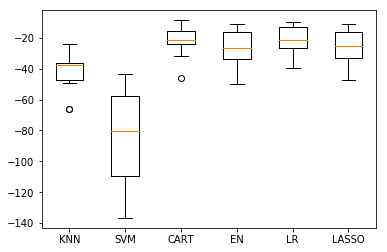

In [117]:
# 采用10折交叉验证来分离数据，通过方差来比较算法的准确度，方差趋近于0，算法准确度越高
# 评估标准
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

# 算法模型初始化
models = {}
models['LR'] = LinearRegression()
models['LASSO'] = Lasso()
models['EN'] = ElasticNet()
models['KNN'] = KNeighborsRegressor()
models['CART'] = DecisionTreeRegressor()
models['SVM'] = SVR()

# 对所有算法使用默认参数，并比较算法的准确度，这里比较的是方差的均值和标准差
results = []
for key in models:
    kfold = KFold(n_splits=num_folds,random_state=seed)
    cv_result = cross_val_score(models[key],X_train,Y_train,cv=kfold,scoring=scoring)
    results.append(cv_result)
    print('%s: %f(%f)'% (key,cv_result.mean(),cv_result.std()))

# 再查看所有的10折交叉分离验证的结果
# 用箱线图
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(models.keys())

#### 正态化数据
猜测也许是因为原始数据中不同特征属性的度量单位不一样，导致有的算法的结果不是很好。  
通过数据转换，将所有数据进行正态化

ScalerLASSO:-26.602585:(8.972576)
ScalerKNN:-20.123490:(12.373834)
ScalerSVM:-29.660002:(16.993025)
ScalerLR:-21.400099:(9.390450)
ScalerEN:-27.944791:(10.570195)


['ScalerLASSO', 'ScalerKNN', 'ScalerSVM', 'ScalerLR', 'ScalerEN']

{'boxes': [<matplotlib.lines.Line2D at 0x19c4e5b0>,
 'caps': [<matplotlib.lines.Line2D at 0x19c4ecf0>,
 'fliers': [<matplotlib.lines.Line2D at 0x19c591d0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x19c59cf0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x19c4e550>,
  <matplotlib.lines.Line2D at 0x18219550>]}

[Text(0,0,'ScalerLASSO'),
 Text(0,0,'ScalerKNN'),
 Text(0,0,'ScalerSVM'),
 Text(0,0,'ScalerLR'),
 Text(0,0,'ScalerEN')]

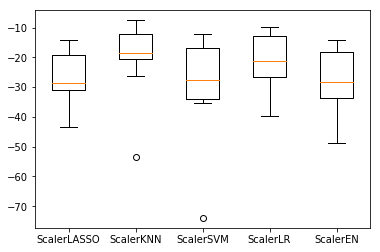

In [153]:
pipelines = {}
pipelines['ScalerLR'] = Pipeline([('Scaler',StandardScaler()),('LR',LinearRegression())])
pipelines['ScalerLASSO'] = Pipeline([('Scaler',StandardScaler()),('LASSO',Lasso())])
pipelines['ScalerEN'] = Pipeline([('Scaler',StandardScaler()),('EN',ElasticNet())])
pipelines['ScalerKNN'] = Pipeline([('Scaler',StandardScaler()),('KNN',KNeighborsRegressor())])
#pipelines['ScalerCART'] = Pipeline([('Scaler',StandardScaler()),('CART',DecisionTreeRegressor)])
pipelines['ScalerSVM'] = Pipeline([('Scaler',StandardScaler()),('SVM',SVR())])
result1s = []
for key in pipelines:
    kfold = KFold(n_splits=num_folds,random_state=seed)
    cv_result = cross_val_score(pipelines[key],X_train,Y_train,cv=kfold,scoring=scoring)
    result1s.append(cv_result)
    print('%s:%f:(%f)'%(key,cv_result.mean(),cv_result.std()))
#result1s.key
pipelines.keys()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(result1s)
ax.set_xticklabels(pipelines.keys())

### 调参改善算法

In [154]:
scaler = StandardScaler().fit(X_train)
rescalerdX = scaler.transform(X_train)
param_grid = {'n_neighbors':[1,3,5,7,9,11,13,15,17,19,21]}
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds,random_state=seed)
grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scoring,cv=kfold)
grid_result = grid.fit(X=rescalerdX,y=Y_train)

print('最优：%s使用%s'%(grid_result.best_score_,grid_result.best_params_))
cv_results = zip(grid_result.cv_results_['mean_test_score'],grid_result.cv_results_['std_test_score'],grid_result.cv_results_['params'])
for mean,std,param in cv_results:
    print('%f (%f) with %r'%(mean,std,param))

最优：-18.1331710671使用{'n_neighbors': 3}
-20.373936 (15.036687) with {'n_neighbors': 1}
-18.133171 (12.958886) with {'n_neighbors': 3}
-20.139550 (12.199280) with {'n_neighbors': 5}
-20.560152 (12.348131) with {'n_neighbors': 7}
-20.382691 (11.617326) with {'n_neighbors': 9}
-21.052064 (11.621184) with {'n_neighbors': 11}
-21.157689 (11.938415) with {'n_neighbors': 13}
-21.538655 (11.532863) with {'n_neighbors': 15}
-22.796125 (11.605158) with {'n_neighbors': 17}
-23.885472 (11.362449) with {'n_neighbors': 19}
-24.364986 (11.920959) with {'n_neighbors': 21}


### 集成算法

ScaledAB-LR: -23.911346(9.704116)
ScaledAB: -14.573093(5.913043)
ScaledAB-KNN: -16.097383(10.637412)
ScaledETR: -9.511587(5.225313)
ScaledRFR: -13.526551(7.624876)
ScaledGBR: -9.281479(3.915986)


{'boxes': [<matplotlib.lines.Line2D at 0x19c66750>,
 'caps': [<matplotlib.lines.Line2D at 0x19c668d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x19ccebf0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x19cce830>,
 'whiskers': [<matplotlib.lines.Line2D at 0x19c66e50>,
  <matplotlib.lines.Line2D at 0x179cf190>]}

[Text(0,0,'ScaledAB-LR'),
 Text(0,0,'ScaledAB'),
 Text(0,0,'ScaledAB-KNN'),
 Text(0,0,'ScaledETR'),
 Text(0,0,'ScaledRFR'),
 Text(0,0,'ScaledGBR')]

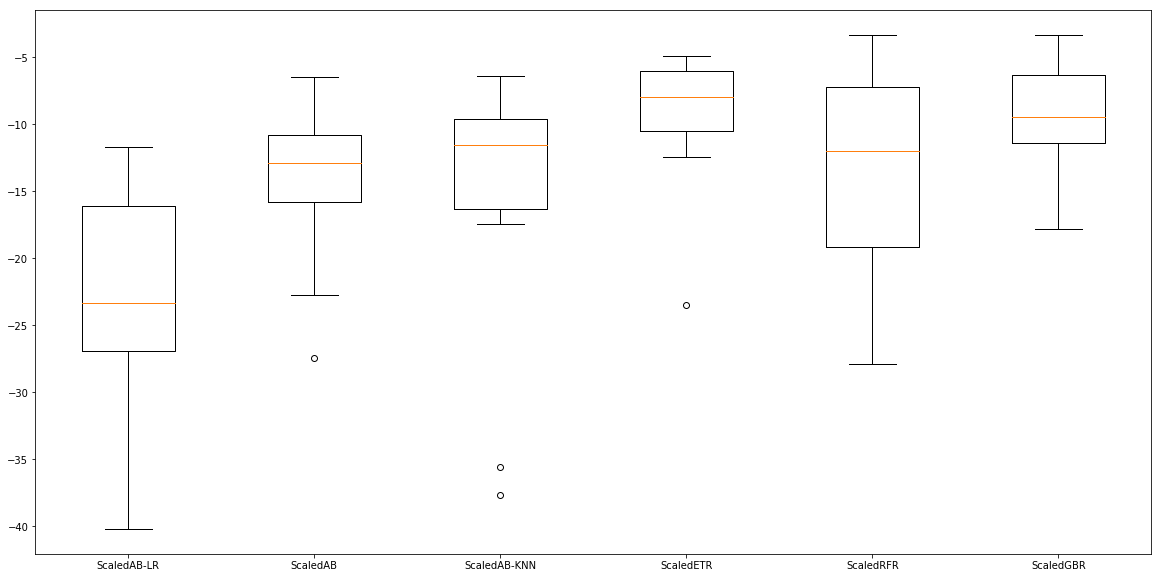

In [157]:
ensembles = {}
ensembles['ScaledAB'] = Pipeline([('Scaler',StandardScaler()),('AB',AdaBoostRegressor())])
# Adaboost K近邻
ensembles['ScaledAB-KNN'] = Pipeline([('Scaler',StandardScaler()),('ABKNN',AdaBoostRegressor(base_estimator=KNeighborsRegressor(n_neighbors=3)))])
# Adaboost 线性回归
ensembles['ScaledAB-LR'] = Pipeline([('Scaler',StandardScaler()),('ABLR',AdaBoostRegressor(LinearRegression()))])

# 随机森林
ensembles['ScaledRFR'] = Pipeline([('Scaler',StandardScaler()),('RFR',RandomForestRegressor())])
# 极端随机树
ensembles['ScaledETR'] = Pipeline([('Scaler',StandardScaler()),('ETR',ExtraTreesRegressor())])
# 随机梯度提升
ensembles['ScaledGBR'] = Pipeline([('Scaler',StandardScaler()),('GBR',GradientBoostingRegressor())])

results = []
for key in ensembles:
    kfold = KFold(n_splits=num_folds,random_state=seed)
    cv_result = cross_val_score(ensembles[key],X_train,Y_train,cv=kfold,scoring=scoring)
    results.append(cv_result)
    print('%s: %f(%f)'% (key,cv_result.mean(),cv_result.std()))
figsize(20,10)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(ensembles.keys())

### 集成算法调参

In [160]:
# GBR调参
scaler = StandardScaler().fit(X_train)
rescalerdX = scaler.transform(X_train)
param_grid = {'n_estimators':[10,50,100,200,300,400,500,600,700,800,900]}
model = GradientBoostingRegressor()
kfold = KFold(n_splits=num_folds,random_state=seed)
grid = GridSearchCV(estimator = model,param_grid=param_grid,scoring=scoring,cv=kfold)
grid_result = grid.fit(X=rescalerdX,y=Y_train)
print('最优：%s使用%s'%(grid_result.best_score_,grid_result.best_params_))

最优：-8.86501791389使用{'n_estimators': 300}


In [161]:
# ET调参
scaler = StandardScaler().fit(X_train)
rescalerdX = scaler.transform(X_train)
param_grid = {'n_estimators':[5,10,20,30,40,50,60,70,80,90,100]}
model = ExtraTreesRegressor()
kfold = KFold(n_splits=num_folds,random_state=seed)
grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scoring,cv=kfold)
grid_result = grid.fit(X=rescalerdX,y=Y_train)
print('最优：%s使用%s'%(grid_result.best_score_,grid_result.best_params_))

最优：-9.06929121287使用{'n_estimators': 20}


### 确定最终模型

In [168]:
# 训练模型
scaler = StandardScaler().fit(X_train)
rescalerdX = scaler.transform(X_train)
gbr = GradientBoostingRegressor(n_estimators=300)
gbr.fit(X=rescalerdX,y=Y_train)


# 评估算法模型
rescalerdX_validation = scaler.transform(X_validation)
predictions = gbr.predict(rescalerdX_validation)
print(mean_squared_error(Y_validation,predictions))

# 保存模型
model_file = './csvs/gbr_test.sav'
with open(model_file,'wb') as model_f:
    # 模型序列化
    dump(model,model_f)
    

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

11.8736837223
